In [40]:
#basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import transformers
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
device = torch.device("mps")
from sklearn.metrics import f1_score,accuracy_score,classification_report,confusion_matrix

### Import dataset from hugging face

In [2]:
#using load_dataset()
emotions = datasets.load_dataset('emotion')

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
#sample
emotions['train'][0]

{'text': 'i didnt feel humiliated', 'label': 0}

### Explore dataset

In [5]:
# setting format of dataset as pandas for exploration
emotions.set_format('pandas')

In [6]:
df = emotions['train'][:]

In [7]:
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
#convert the labels into strings
def int2str_label(row):
    return emotions['train'].features['label'].int2str(row)

In [9]:
df['emotion'] = df['label'].apply(int2str_label)

In [10]:
df.head()

,text,label,emotion
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


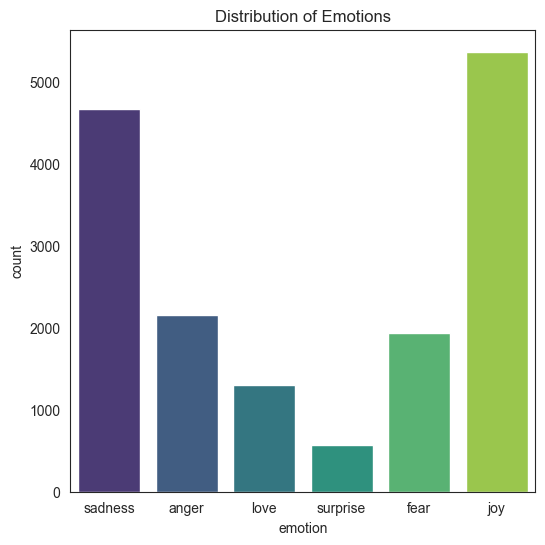

In [11]:
%matplotlib inline
sns.set_style('white')
plt.figure(figsize=(6,6))
sns.countplot(x='emotion',data=df,palette='viridis')
plt.title('Distribution of Emotions')
plt.show()

In [12]:
df['wrd_len'] = df['text'].str.split().apply(len)

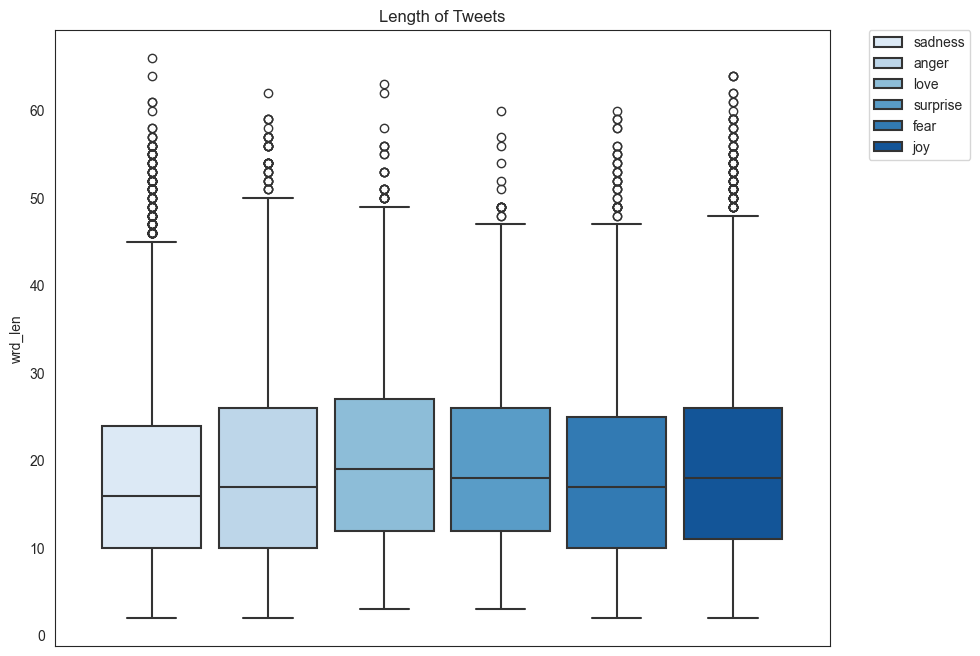

In [13]:
plt.figure(figsize=(10,8))
sns.boxplot(y='wrd_len',data=df,palette='Blues',hue='emotion',saturation=0.9,gap=0.15,width=0.9,linewidth=1.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Length of Tweets')
plt.show()

In [14]:
#now we reset the format
emotions.reset_format()

In [15]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### tokenizer

In [16]:
#using autotokenizer
#using distilberts tokenizer
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [17]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [18]:
#testing
text = "this is a text for tokenizer to convert or encode"
out = tokenizer(text)
#tokenizer returns a dict of input ids as well as attention_mask

In [19]:
out

{'input_ids': [101, 2023, 2003, 1037, 3793, 2005, 19204, 17629, 2000, 10463, 2030, 4372, 16044, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
input_ids = out.input_ids
tokenizer.convert_ids_to_tokens(input_ids)

['[CLS]',
 'this',
 'is',
 'a',
 'text',
 'for',
 'token',
 '##izer',
 'to',
 'convert',
 'or',
 'en',
 '##code',
 '[SEP]']

### tokenizing whole dataset

In [21]:
#using map
def apply_tokenizer(batch):
    return tokenizer(batch['text'],padding=True,truncation=True)

In [22]:
#create new dataset containing encoded text or tokenized text
emotions_encoded = emotions.map(apply_tokenizer,batched=True,batch_size=None)

In [23]:
#notice attention mask for padding is 0, essentially telling model to "ignore" it
print(emotions_encoded['train'][1])

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0, 'input_ids': [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


### Set format of dataset to tensors

In [24]:
emotions_encoded.set_format(type="pt",columns=['input_ids','attention_mask','label'])

In [25]:
print(emotions_encoded['train'][1])

{'label': tensor(0), 'input_ids': tensor([  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
         9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
         2003,  8300,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,

### Importing model from HF

In [26]:
#this auto model adds a classification head to the pre trained model
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### set metrics for training

In [28]:
#set f1 and acc as metrics
#it receives a pred object which has predictions and label_ids in namedtuple
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {'f1':f1,'acc':acc}

### Define hyperparamters for training

In [29]:
#using TrainingAruguments module
from transformers import TrainingArguments
#define batch size for eval and train
batch_size = 32
#number of logging steps needed
logging_steps = len(emotions['train'])//batch_size
#set a dir for output
model_name = 'Sentiment_tweets_distilbert'
#set learning rate
learning_rate=2e-5
#set epochs
num_epochs = 3
#log level
log_level = "error"
#set weight decay values
weight_decay = 0.01
#create instance of Training Arguments
training_args = TrainingArguments(output_dir=model_name,
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 log_level=log_level,
                                 logging_steps=logging_steps,
                                 learning_rate=learning_rate,
                                 weight_decay=weight_decay,
                                 num_train_epochs=num_epochs,
                                 push_to_hub=True,
                                 disable_tqdm=False,
                                 eval_strategy="epoch")


### now define a Trainer

In [30]:
from huggingface_hub import notebook_login
notebook_login()

In [31]:
from transformers import Trainer
trainer = Trainer(model=model,
                 compute_metrics=compute_metrics,
                 args=training_args,
                 train_dataset=emotions_encoded['train'],
                 eval_dataset=emotions_encoded['validation'],
                 tokenizer=tokenizer)

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.607600,0.224300,0.919172,0.918500
2,0.164100,0.168366,0.929703,0.930000
3,0.119500,0.152520,0.935851,0.936000


TrainOutput(global_step=1500, training_loss=0.29705032348632815, metrics={'train_runtime': 421.6451, 'train_samples_per_second': 113.84, 'train_steps_per_second': 3.557, 'total_flos': 1080514292544000.0, 'train_loss': 0.29705032348632815, 'epoch': 3.0})

In [33]:
y_val = trainer.predict(emotions_encoded['validation'])

In [37]:
preds = np.argmax(y_val.predictions,axis=1)

In [39]:
labels = np.array(emotions_encoded['validation']['label'])

In [41]:
print(classification_report(labels,preds))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       550
           1       0.95      0.95      0.95       704
           2       0.88      0.87      0.87       178
           3       0.94      0.94      0.94       275
           4       0.87      0.92      0.89       212
           5       0.93      0.79      0.85        81

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



In [51]:
def forward_pass_with_labels(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits,axis=-1)
        loss = F.cross_entropy(output.logits,batch['label'].to(device),reduction="none")
    return {'loss':loss.cpu().numpy(),"prediction_label":pred_label.cpu().numpy()}

In [52]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask','label'])

In [53]:
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_labels,
                                                                   batched=True,batch_size=4)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [54]:
emotions_encoded.set_format("pandas")

In [57]:
cols = ['text','label','prediction_label','loss']

In [58]:
df_test = emotions_encoded['validation'][:][cols]

In [59]:
df_test['label'] = df_test['label'].apply(int2str_label)

In [60]:
df_test['prediction_label'] = df_test['prediction_label'].apply(int2str_label)

In [64]:
df_test.sort_values('loss',ascending=False).head(15)

,text,label,prediction_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.100559
1111,im lazy my characters fall into categories of ...,joy,fear,6.815245
1963,i called myself pro life and voted for perry w...,joy,sadness,6.555830
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.553863
177,im sure much of the advantage is psychological...,sadness,joy,6.423048
405,i have been feeling extraordinarily indecisive...,fear,joy,5.483036
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.381291
1840,id let you kill it now but as a matter of fact...,joy,fear,5.200083
1801,i feel that he was being overshadowed by the s...,love,sadness,5.095189
292,i can say is that i feel like myself when i pu...,love,joy,4.692630


In [66]:
df_test.sort_values('loss').head(25)

,text,label,prediction_label,loss
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.002866
69,i have no extra money im worried all of the ti...,sadness,sadness,0.002900
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.002915
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.002925
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.002945
1310,i feel like an ungrateful asshole,sadness,sadness,0.002947
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.002971
76,i feel like im an unwelcome presence whenever ...,sadness,sadness,0.002974
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.002987
1886,i feel unloved and know im hated,sadness,sadness,0.002989


In [67]:
trainer.push_to_hub(commit_message="done")

events.out.tfevents.1732204740.Aadityas-MacBook-Pro.local.10553.0:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Sharpaxis/Sentiment_tweets_distilbert/commit/4e5aed2765d5fc9756655725a17fae7eab5dda27', commit_message='done', commit_description='', oid='4e5aed2765d5fc9756655725a17fae7eab5dda27', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Sharpaxis/Sentiment_tweets_distilbert', endpoint='https://huggingface.co', repo_type='model', repo_id='Sharpaxis/Sentiment_tweets_distilbert'), pr_revision=None, pr_num=None)

### Using the fine tuned model to make predictions

In [68]:
from transformers import pipeline

In [69]:
model_id = 'Sharpaxis/Sentiment_tweets_distilbert'
classifier = pipeline("text-classification",model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

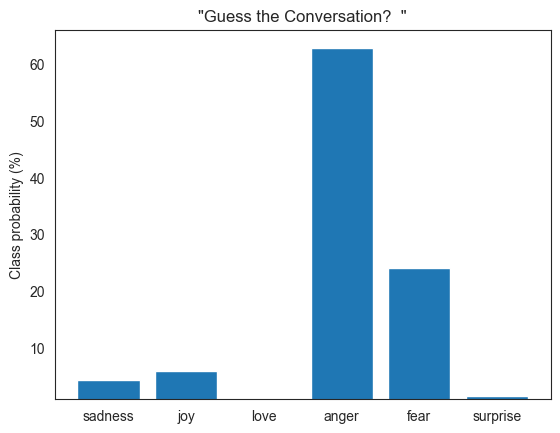

In [116]:
sample_tweet = 'Guess the Conversation?  '
preds = classifier(sample_tweet,return_all_scores=True)
pred_df = pd.DataFrame(preds[0])
labels = emotions_encoded['train'].features['label'].names
plt.bar(labels,100*pred_df['score'],color='C0')
plt.title(f'"{sample_tweet}"')
plt.ylabel("Class probability (%)")
plt.ylim(1)
plt.show()